# NLP to determine Tweet Sentiment










# Overview

# Data

In [22]:
#import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# import libraries for imbalanced class 
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

# Objective: identify negative tweets

In [2]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# rename columns for my sanity 
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# clean sentiment value names
sentiment_replace = {'Positive emotion': 'positive', 'Negative emotion': 'negative'}
df.sentiment.replace(sentiment_replace, inplace=True)

In [4]:
df.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

In [5]:
df.sentiment.value_counts()

No emotion toward brand or product    5389
positive                              2978
negative                               570
I can't tell                           156
Name: sentiment, dtype: int64

In [6]:
corpus = df[(df.sentiment == 'positive') | (df.sentiment == 'negative')].drop('product', axis=1)
corpus.head()

,text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,positive
3,@sxsw I hope this year's festival isn't as cra...,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive


In [7]:
corpus.sentiment.replace(('negative', 'positive'), (1, 0), inplace=True)
corpus.sentiment.value_counts(normalize=True)

0    0.839346
1    0.160654
Name: sentiment, dtype: float64

## Modeling

In [9]:
# Define X, y
X = corpus['text'] # Tweet content is our feature
y = corpus['sentiment'] #binary target for negative and positive emotions

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) # split data into training and testing

In [10]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)
df_cv = pd.DataFrame(cv_X_train.toarray(), columns=cv.get_feature_names())

C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


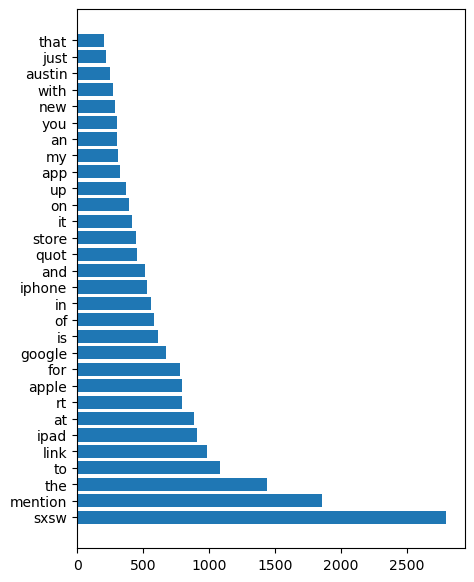

In [14]:
plt.figure(figsize=(5,7))
plt.barh(df_cv.sum().sort_values(ascending=False)[:30].index, df_cv.sum().sort_values(ascending=False)[:30]);

C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


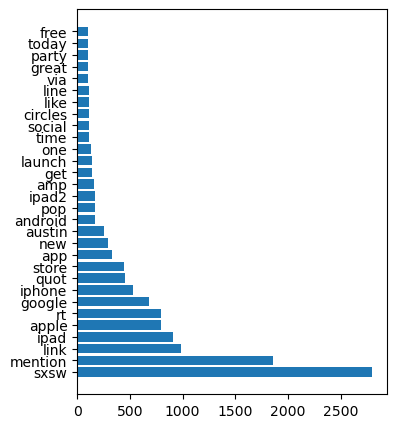

In [13]:
sw = stopwords.words('english')
sw_cv = CountVectorizer(stop_words=sw)
sw_cv_X_train = sw_cv.fit_transform(X_train)
sw_cv_X_test = sw_cv.transform(X_test)
sw_df_cv = pd.DataFrame(sw_cv_X_train.toarray(), columns=sw_cv.get_feature_names())
plt.figure(figsize=(4,5))
plt.barh(sw_df_cv.sum().sort_values(ascending=False)[:30].index, sw_df_cv.sum().sort_values(ascending=False)[:30]);

C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


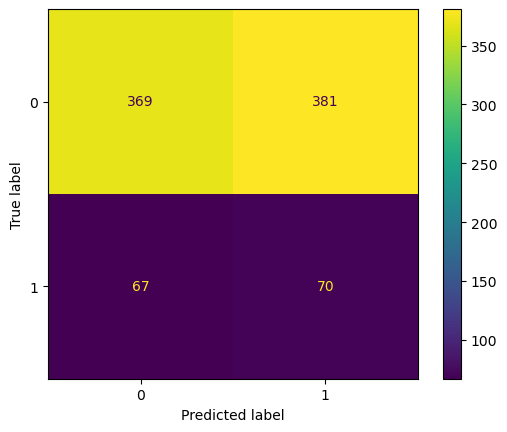

In [19]:
dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(cv_X_train, y_train)
y_pred_dummy_sm = dummy.predict(cv_X_test)
plot_confusion_matrix(estimator=dummy, X=cv_X_test, y_true=y_test);

In [23]:
def mnb(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {'class_prior': [[0.5,0.5],[0.45,0.55],[0.4,0.6],[0.35,0.65], [0.3,0.7],[0.25,0.75]]}
    
    # Instantiate MultinomialNB model 
    mnb = MultinomialNB()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=mnb, param_grid=grid, cv=cv, scoring='recall')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    print(f'Best parameters: {gs.best_params_}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    score = gs.score(X_test, y_test)
    print(f'Test f1: {score}')
    recall = recall_score(y_test, y_pred)
    print(f'Recall Score: {recall}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score Score: {accuracy}')
    precision = precision_score(y_test, y_pred)
    print(f'Precision score: {precision}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    return {'Accuracy': round(100*accuracy,1), 'Sensitivity': round(100*recall,1)}

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.5960438385458434
Test f1: 0.5474452554744526
Recall Score: 0.5474452554744526
Accuracy score Score: 0.85456595264938
Precision score: 0.528169014084507


C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will 

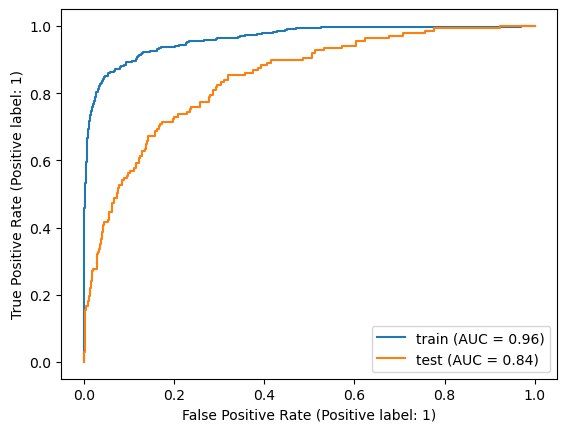

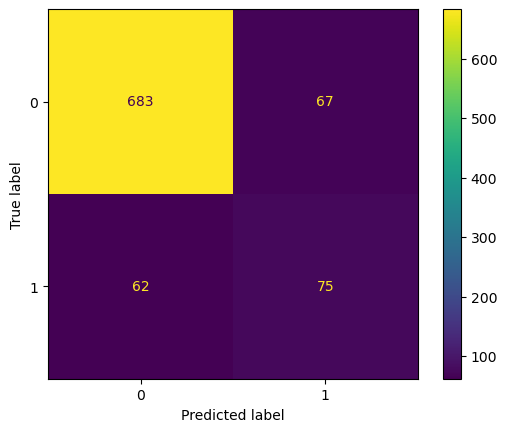

In [24]:
cv_mnb_results = mnb(cv_X_train, cv_X_test, y_train, y_test)

In [28]:
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(cv_X_train, y_train) 
# notice the class imbalance is corrected
y_train_sm.value_counts()

0    2228
1    2228
Name: sentiment, dtype: int64

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.8766614601703028
Test f1: 0.656934306569343
Recall Score: 0.656934306569343
Accuracy score Score: 0.8196166854565953
Precision score: 0.4433497536945813


C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will 

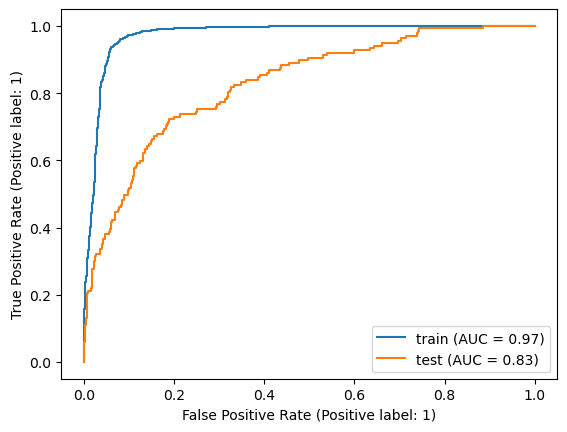

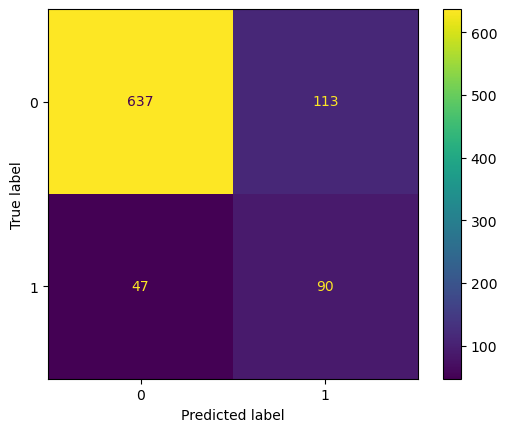

In [30]:
cv_mnb_sm_results = mnb(X_train_sm, cv_X_test, y_train_sm, y_test)

# Results


# Conclusions
